In [ ]:
%pip install jovian

# Import libraries
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
dataframe = pd.read_csv("car_price_data.csv")
dataframe = dataframe.drop(['Car_Name', 'Kms_Driven'], axis=1) # Exclude columns that we won't use
dataframe

,Year,Selling_Price,Present_Price,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...
296,2016,9.50,11.60,Diesel,Dealer,Manual,0
297,2015,4.00,5.90,Petrol,Dealer,Manual,0
298,2009,3.35,11.00,Petrol,Dealer,Manual,0
299,2017,11.50,12.50,Diesel,Dealer,Manual,0


In [ ]:
num_rows = len(dataframe)
input_cols = ['Year','Selling_Price','Fuel_Type','Seller_Type','Transmission','Owner']
categorical_cols = ['Year', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']
output_cols = ['Present_Price']

In [ ]:
print('Minimun Charge: {}'.format(dataframe.Present_Price.min()))
print('Average Charge: {}'.format(dataframe.Present_Price.mean()))
print('Maximun Charge: {}'.format(dataframe.Present_Price.max()))

In [ ]:
plt.title("Distribution of Showroom Price")
sns.distplot(dataframe.Present_Price, kde=False);

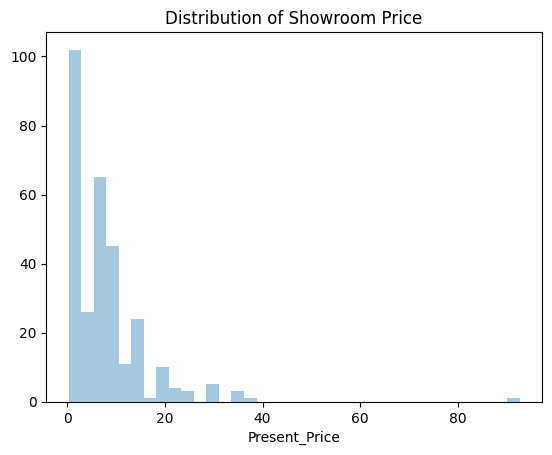

In [ ]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataframe) # Create arrays for inputs and targets
inputs_array, targets_array

inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [ ]:
dataset = TensorDataset(inputs, targets)

In [ ]:
val_percent = 0.1
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size]) # split dataset into 2 parts of the desired length

In [ ]:
batch_size = 50
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)

In [ ]:
class CarsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)  
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [ ]:
model = CarsModel()

result = evaluate(model, val_loader) # Use the evaluate function
print(result)

In [ ]:
epochs = 100
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
epochs = 100
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
epochs = 100
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
epochs = 100
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
epochs = 100
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
val_loss = [result] + history1 + history2 + history3 + history4 + history5
print(val_loss)
val_loss_list = [vl['val_loss'] for vl in val_loss]

plt.plot(val_loss_list, '-x')

plt.xlabel('epochs')
plt.ylabel('losses')

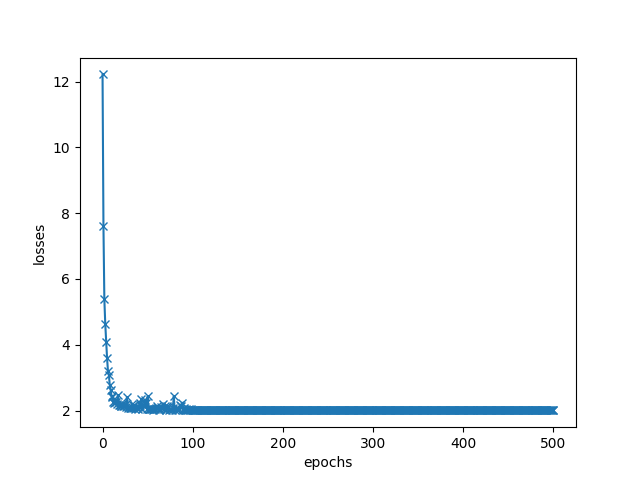

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)